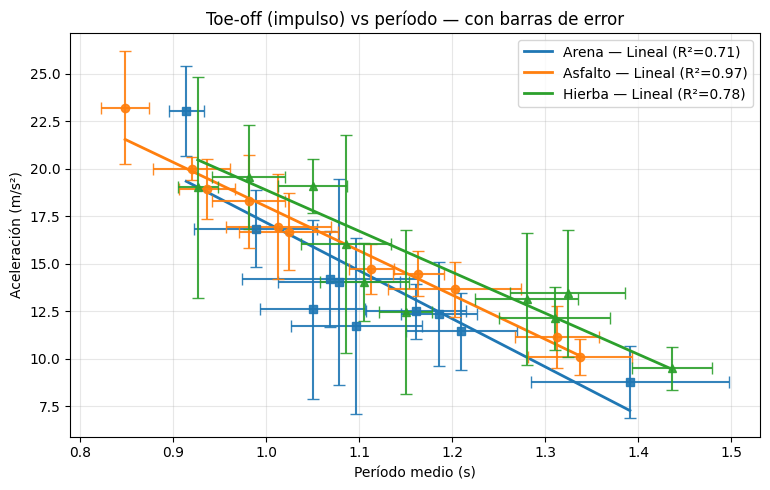

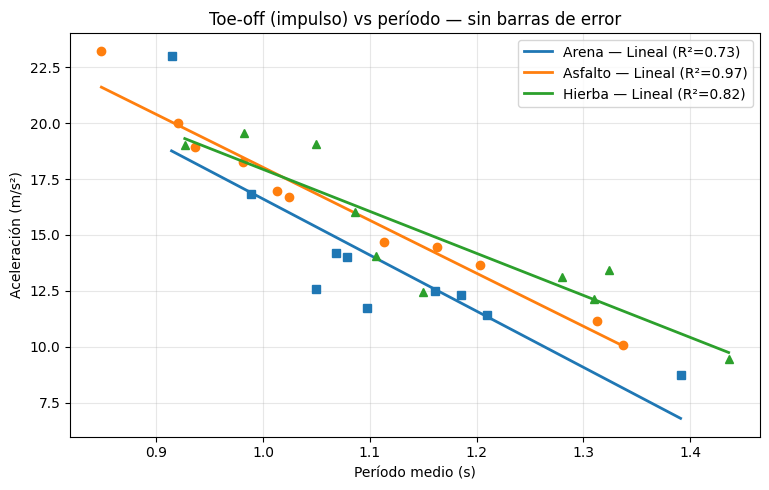

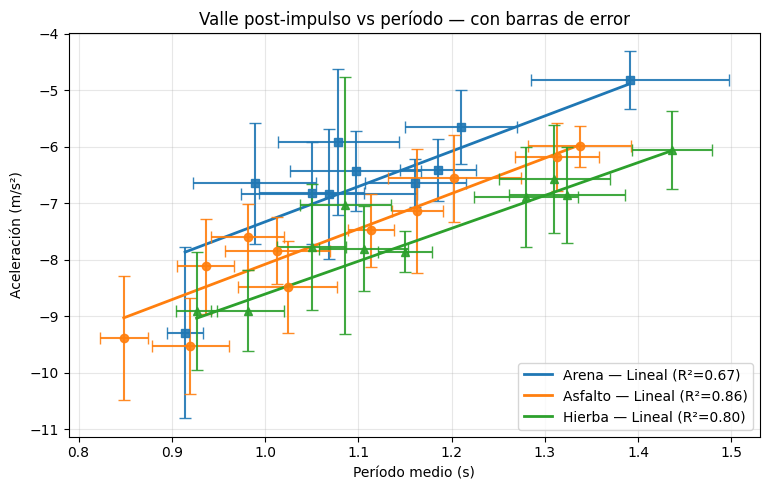

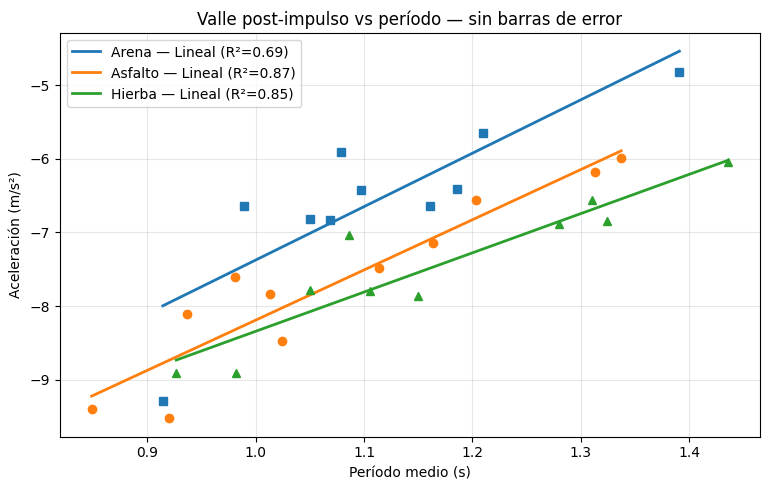

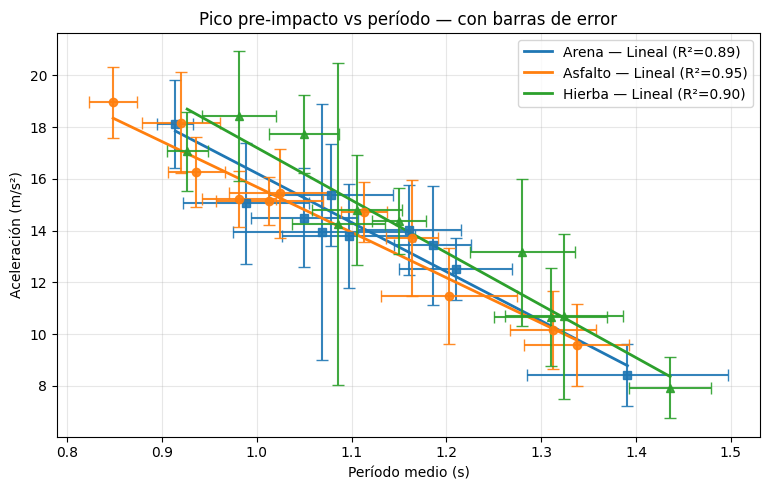

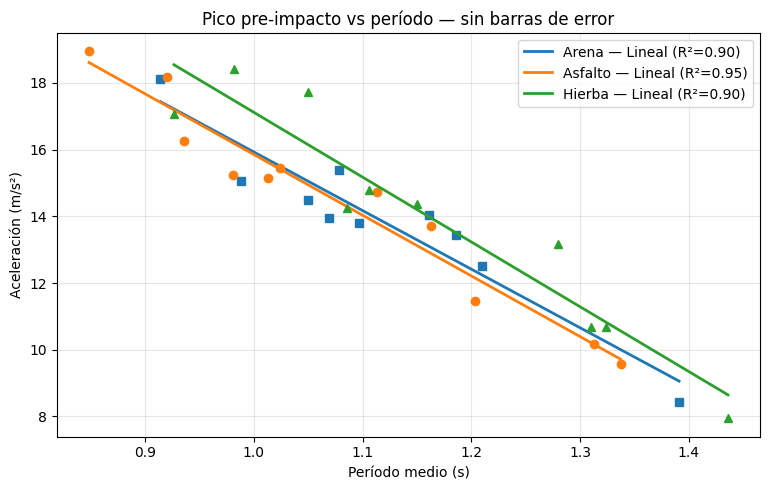

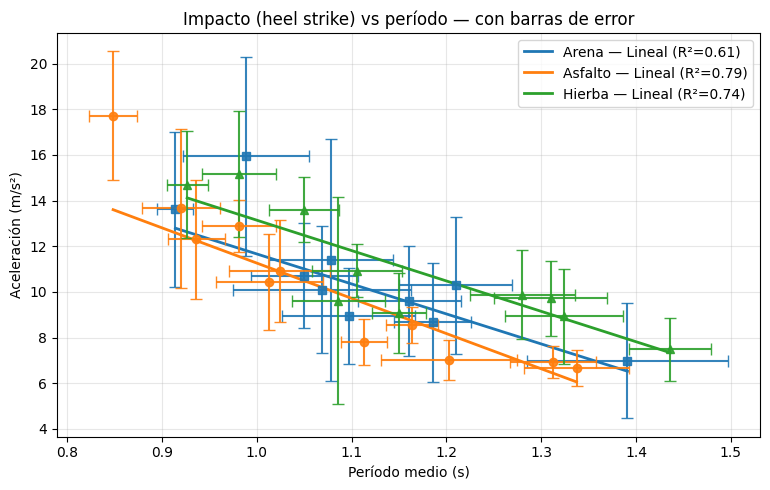

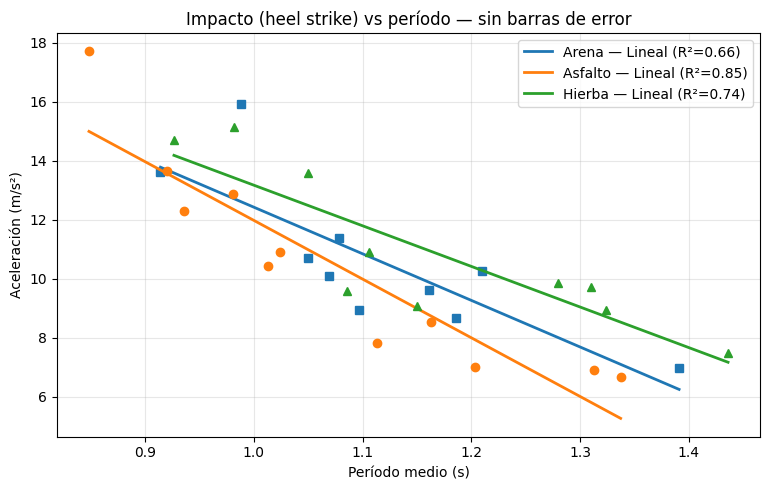


Resumen por muestra (para referencia):
surface                             file  sample_id  t_start   t_end  period_mean  period_std  period_n  toe_mean  toe_std  toe_n  valley_mean  valley_std  valley_n  pre_mean  pre_std  pre_n  impact_mean  impact_std  impact_n
  Arena   AccelerometerArenaTobillo1.csv          1    8.500  19.000        1.210       0.060         7    11.440    2.037      8       -5.652       0.650         8    12.520    1.197      8       10.279       3.004         8
  Arena   AccelerometerArenaTobillo1.csv          2   30.000  40.000        1.097       0.070         7    11.726    4.617      8       -6.428       0.702         8    13.791    2.025      8        8.940       2.099         8
  Arena   AccelerometerArenaTobillo1.csv          3   52.000  68.000        1.391       0.106        10     8.756    1.901     11       -4.821       0.515        11     8.431    1.193     11        6.983       2.525        11
  Arena   AccelerometerArenaTobillo1.csv          4   80

In [1]:
# %%
# Detección robusta + resumen por muestra + 4 pares de plots con AJUSTE LINEAL por superficie
# - Ajuste SIEMPRE lineal (y = a + b x)
# - Si hay barras de error: ponderado por 1/sigma^2; si no, OLS.
# - Se grafica la recta y se muestra R² en la leyenda.
# - Dos gráficos por métrica: con barras de error y sin barras (ambos con la recta).

import os, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# ===================== Configuración =====================
DATA_DIR = "."
FS = 100.0  # Hz

# -------- INTERVALOS (definitivos) --------
MUESTRAS = {
    # ----- ARENA -----
    "AccelerometerArenaTobillo1.csv": [
        (8.5, 19.0), (30.0, 40.0), (52.0, 68.0), (80.0, 93.0), (107.5, 118.5),
    ],
    "AccelerometerArenaTobillo2.csv": [
        (10.0, 25.0), (35.0, 46.0), (62.0, 70.5), (79.5, 90.0), (102.0, 112.0),
    ],
    # ----- ASFALTO -----
    "AccelerometerAsfaltoTobillo1.csv": [(25.0, 39.0)],
    "AccelerometerAsfaltoTobillo2.csv": [(30.25, 47.0)],  # corregido nombre
    "AccelerometerAsfaltoTobillo3.csv": [(12.5, 26.0)],
    "AccelerometerAsfaltoTobillo4.csv": [(15.0, 27.0)],
    "AccelerometerAsfaltoTobillo5.csv": [(15.0, 25.0)],
    "AccelerometerAsfaltoTobillo6.csv": [(26.0, 41.0)],
    "AccelerometerAsfaltoTobillo7.csv": [(26.0, 36.25)],
    "AccelerometerAsfaltoTobillo8.csv": [(18.0, 26.0), (39.0, 57.5), (70.0, 82.0), (94.0, 104.0)],
    # ----- HIERBA -----
    "AccelerometerHierbaTobillo1.csv": [
        (19.0, 34.5), (42.0, 61.0), (68.0, 81.0), (91.0, 108.0), (126.5, 142.5), (158.0, 169.0),
    ],
    "AccelerometerHierbaTobillo2.csv": [
        (9.0, 17.0), (28.0, 36.0), (47.0, 57.5), (68.0, 77.0),
    ],
}

# ===================== Utilidades I/O =====================
def natural_key(s: str):
    return [int(t) if t.isdigit() else t.lower() for t in re.split(r"(\d+)", s)]

def resolve_path(fname, data_dir="."):
    """Busca exacto y luego case-insensitive en data_dir."""
    p = os.path.join(data_dir, fname)
    if os.path.exists(p):
        return p
    try:
        for f in os.listdir(data_dir):
            if f.lower() == fname.lower():
                return os.path.join(data_dir, f)
    except FileNotFoundError:
        pass
    raise FileNotFoundError(f"No se encontró {fname} en {os.path.abspath(data_dir)}")

def cargar_y(path):
    try:
        df = pd.read_csv(path)
    except UnicodeDecodeError:
        df = pd.read_csv(path, encoding="latin-1")
    df.columns = [c.strip().lower() for c in df.columns]
    if not {"seconds_elapsed", "y"}.issubset(df.columns):
        raise ValueError(f"Faltan columnas en {os.path.basename(path)}: {df.columns.tolist()}")
    t  = pd.to_numeric(df["seconds_elapsed"], errors="coerce").to_numpy()
    ay = pd.to_numeric(df["y"],               errors="coerce").to_numpy()
    m = np.isfinite(t) & np.isfinite(ay)
    return t[m], ay[m]

def etiqueta_superficie(fname: str):
    f = fname.lower()
    if "asfalto" in f: return "Asfalto"
    if "arena"   in f: return "Arena"
    if "hierba"  in f: return "Hierba"
    return "Desconocida"

# ===================== Parámetros de detección =====================
ABS_THR_POS = 1.0
ABS_THR_NEG = 1.0
TOEOFF_MIN_HEIGHT_FACTOR = 0.2
TOEOFF_LEAD_MIN = 0.12
TOEOFF_LEAD_MAX = 0.70
TOEOFF_LOOKBACK = 0.80

VALLEY_MIN_DIST_S        = { "Asfalto":0.30, "Arena":0.55, "Hierba":0.45 }
VALLEY_MIN_DEPTH_SURF    = { "Asfalto":3.5, "Arena":3.2, "Hierba":2.5 }
VALLEY_MIN_PROM          = 2.0
MIN_LOBE_WIDTH_S         = { "Asfalto":0.08, "Arena":0.12, "Hierba":0.12 }
VENTANA_MEDIA_SURF       = { "Asfalto": 5, "Arena": 5, "Hierba": 5 }
THR_SCALE                = { "Asfalto": 0.9, "Arena": 0.9, "Hierba": 0.8 }
PEAK_MIN_DIST_S_SURF     = { "Asfalto": 0.12, "Arena": 0.12, "Hierba": 0.10 }

# pre-impacto por pendiente
PRE_MIN_DT_AFTER_VALLEY_S = { "Asfalto":0.05, "Arena":0.06, "Hierba":0.07 }
PRE_MIN_RISE_FACT         = { "Asfalto":0.25, "Arena":0.30, "Hierba":0.30 }

# impacto
IMPACT_MIN_DT_AFTER_PRE_S = { "Asfalto":0.03, "Arena":0.03, "Hierba":0.03 }
IMPACT_MAX_GAP_SURF       = { "Asfalto":0.30, "Arena":0.35, "Hierba":0.45 }
IMPACT_PROM_K             = { "Asfalto":0.25, "Arena":0.25, "Hierba":0.20 }

# ===================== Helpers de señal =====================
def media_movil(x, k):
    if k <= 1: return x
    return np.convolve(x, np.ones(k)/k, mode="same")

def mad_std(x):
    med = np.median(x)
    mad = np.median(np.abs(x - med))
    return 1.4826*mad if mad>0 else np.std(x)

def zero_cross_lobe_width(time, y, center_idx):
    n = len(y)
    tL = None
    for i in range(center_idx-1, 0, -1):
        if y[i] >= 0 and y[i+1] < 0:
            frac = y[i] / (y[i] - y[i+1] + 1e-12)
            tL = time[i] + frac*(time[i+1]-time[i]); break
    tR = None
    for i in range(center_idx, n-1):
        if y[i] < 0 and y[i+1] >= 0:
            frac = (-y[i]) / (y[i+1] - y[i] + 1e-12)
            tR = time[i] + frac*(time[i+1]-time[i]); break
    if tL is None or tR is None: return 0.0
    return max(0.0, tR - tL)

def merge_close_valleys_by_width(time, y, valleys, min_sep_s):
    if len(valleys) <= 1: return np.array(valleys, dtype=int)
    keep = [valleys[0]]
    for v in valleys[1:]:
        if time[v] - time[keep[-1]] < min_sep_s:
            w_prev = zero_cross_lobe_width(time, y, keep[-1])
            w_curr = zero_cross_lobe_width(time, y, v)
            if w_curr > w_prev: keep[-1] = v
        else:
            keep.append(v)
    return np.array(keep, dtype=int)

def first_local_max_after(y, start_idx, end_idx, min_dt_samples, base_val, min_rise, require_positive=False):
    i0 = int(start_idx + max(1, min_dt_samples))
    i1 = max(i0+1, int(end_idx)-1)
    for i in range(i0, i1):
        if y[i] > y[i-1] and y[i] >= y[i+1]:
            if (y[i] - base_val) >= min_rise and (not require_positive or y[i] > 0.0):
                return i
    return None

# ===================== Núcleo detección =====================
def detectar_eventos(surface, time, ay):
    ay_s  = media_movil(ay, VENTANA_MEDIA_SURF[surface])
    sigma = mad_std(ay_s)
    thr_pos = max(ABS_THR_POS, THR_SCALE[surface]*sigma)
    thr_neg = max(ABS_THR_NEG, THR_SCALE[surface]*sigma)

    # Valles
    dist0 = min(0.20, VALLEY_MIN_DIST_S[surface])
    valleys0, _ = find_peaks(-ay_s, height=max(thr_neg, VALLEY_MIN_DEPTH_SURF[surface]),
                             prominence=VALLEY_MIN_PROM, distance=int(dist0*FS))
    valleys1 = [v for v in valleys0 if zero_cross_lobe_width(time, ay_s, v) >= MIN_LOBE_WIDTH_S[surface]]
    valleys1 = np.array(sorted(valleys1), dtype=int)
    valleys  = merge_close_valleys_by_width(time, ay_s, valleys1, VALLEY_MIN_DIST_S[surface])

    # Picos positivos globales
    pos_peaks, _ = find_peaks(ay_s, height=thr_pos, distance=int(PEAK_MIN_DIST_S_SURF[surface]*FS))

    # Toe-off inicial
    toeoff_inicial, toeoff0_idx = None, None
    if len(valleys):
        v_first = valleys[0]
        a = max(0, v_first - int(TOEOFF_LEAD_MAX*FS))
        b = max(0, v_first - int(TOEOFF_LEAD_MIN*FS))
        cand = pos_peaks[(pos_peaks >= a) & (pos_peaks <= b)]
        if cand.size:
            toeoff0_idx = cand[np.argmax(ay_s[cand])]
        else:
            seg = ay_s[a:b] if b > a else np.array([])
            if seg.size:
                j = np.argmax(seg)
                if seg[j] > max(TOEOFF_MIN_HEIGHT_FACTOR*sigma, 0.0):
                    toeoff0_idx = a + j
        if toeoff0_idx is not None:
            toeoff_inicial = (time[toeoff0_idx], ay_s[toeoff0_idx])

    # Ciclos valle→valle (+ último para sombrear)
    cycles = [(valleys[i], valleys[i+1]) for i in range(len(valleys)-1)]
    if len(valleys) >= 1 and (not cycles or cycles[-1][1] < len(ay_s)-1):
        cycles.append((valleys[-1], len(ay_s)-1))

    # Por ciclo
    eventos = []
    for (start, end) in cycles:
        if end - start < max(12, int(0.25*FS)):
            continue

        # Pre-impacto
        min_dt_smp = int(PRE_MIN_DT_AFTER_VALLEY_S[surface]*FS)
        rise_thr   = max(0.5, PRE_MIN_RISE_FACT[surface]*sigma)
        pre_idx_i  = first_local_max_after(
            ay_s, start_idx=start, end_idx=end,
            min_dt_samples=min_dt_smp, base_val=ay_s[start],
            min_rise=rise_thr, require_positive=True
        )
        pre_idx = np.nan if pre_idx_i is None else float(pre_idx_i)

        # Impacto (mejor candidato en ventana)
        imp_idx = np.nan
        if np.isfinite(pre_idx):
            pre_i = int(pre_idx)
            left  = pre_i + int(IMPACT_MIN_DT_AFTER_PRE_S[surface]*FS)
            right = min(end-1, pre_i + int(IMPACT_MAX_GAP_SURF[surface]*FS))
            if right > left:
                seg = ay_s[left:right]
                prom_min = max(0.3, IMPACT_PROM_K[surface]*sigma)
                pks, props = find_peaks(seg, prominence=prom_min)
                pks = np.array([p for p in pks if seg[p] > 0.0], dtype=int)
                if pks.size:
                    best_rel = pks[np.argmax(seg[pks])]
                    imp_idx = float(left + best_rel)
                else:
                    cand_i = first_local_max_after(
                        ay_s, start_idx=pre_i, end_idx=right,
                        min_dt_samples=int(0.01*FS), base_val=ay_s[pre_i],
                        min_rise=0.0, require_positive=True
                    )
                    if cand_i is not None:
                        imp_idx = float(cand_i)

        # Toe-off del ciclo
        toe_idx = np.nan
        left_toe = max(start, end - int(TOEOFF_LOOKBACK*FS))
        tail = pos_peaks[(pos_peaks >= left_toe) & (pos_peaks < end)]
        if tail.size:
            toe_idx = float(tail[-1])
        else:
            seg = ay_s[left_toe:end]
            if seg.size:
                j = np.argmax(seg)
                if seg[j] > max(0.1, TOEOFF_MIN_HEIGHT_FACTOR*sigma):
                    toe_idx = float(left_toe + j)

        if not np.isnan(toe_idx):
            eventos.append(dict(
                t_toe=time[int(toe_idx)], a_toe=float(ay_s[int(toe_idx)]),
                t_valley=time[int(start)], a_valley=float(ay_s[int(start)]),
                t_pre=(time[int(pre_idx)] if np.isfinite(pre_idx) else np.nan),
                a_pre=(float(ay_s[int(pre_idx)]) if np.isfinite(pre_idx) else np.nan),
                t_impact=(time[int(imp_idx)] if np.isfinite(imp_idx) else np.nan),
                a_impact=(float(ay_s[int(imp_idx)]) if np.isfinite(imp_idx) else np.nan),
            ))

    return ay_s, eventos, cycles, toeoff_inicial

# ---------- helpers de stats ----------
def stats_de_eventos(eventos):
    arr = pd.DataFrame(eventos) if eventos else pd.DataFrame(columns=["a_toe","a_valley","a_pre","a_impact"])
    def _ms(col):
        v = pd.to_numeric(arr[col], errors="coerce").dropna()
        return dict(mean=float(v.mean()) if len(v) else np.nan,
                    std=float(v.std(ddof=1)) if len(v)>1 else np.nan,
                    n=int(len(v)))
    return {
        "Toe-off (impulso)"    : _ms("a_toe"),
        "Valle post-impulso"   : _ms("a_valley"),
        "Pico pre-impacto"     : _ms("a_pre"),
        "Impacto (heel strike)": _ms("a_impact"),
    }

def period_stats_from_cycles(tt, cycles):
    periods = []
    n = len(tt)
    for (s, e) in cycles:
        if e < n-1:
            periods.append(float(tt[e] - tt[s]))
    if len(periods) == 0:
        return np.nan, np.nan, 0
    periods = np.asarray(periods, dtype=float)
    return float(periods.mean()), float(periods.std(ddof=1)) if len(periods)>1 else np.nan, int(len(periods))

def resumen_muestra_row(surface, fname, sample_id, t0, t1, tt, evs, cycles):
    s = stats_de_eventos(evs)
    p_mean, p_std, p_n = period_stats_from_cycles(tt, cycles)
    row = {
        "surface": surface, "file": fname, "sample_id": sample_id,
        "t_start": t0, "t_end": t1,
        "period_mean": p_mean, "period_std": p_std, "period_n": p_n,
        "toe_mean": s["Toe-off (impulso)"]["mean"], "toe_std": s["Toe-off (impulso)"]["std"], "toe_n": s["Toe-off (impulso)"]["n"],
        "valley_mean": s["Valle post-impulso"]["mean"], "valley_std": s["Valle post-impulso"]["std"], "valley_n": s["Valle post-impulso"]["n"],
        "pre_mean": s["Pico pre-impacto"]["mean"], "pre_std": s["Pico pre-impacto"]["std"], "pre_n": s["Pico pre-impacto"]["n"],
        "impact_mean": s["Impacto (heel strike)"]["mean"], "impact_std": s["Impacto (heel strike)"]["std"], "impact_n": s["Impacto (heel strike)"]["n"],
    }
    return row

def procesar_muestra(fname, sample_id, t0, t1):
    path = resolve_path(fname, DATA_DIR)
    t, ay = cargar_y(path); surface = etiqueta_superficie(fname)
    m = (t >= t0) & (t <= t1); tt = t[m] - t0; yy = ay[m]
    ay_s, evs, cycles, toeoff0 = detectar_eventos(surface, tt, yy)
    return resumen_muestra_row(surface, fname, sample_id, t0, t1, tt, evs, cycles)

# ===================== Ajuste lineal =====================
def fit_linear(x, y, yerr=None):
    """
    Ajuste lineal y = a + b x.
    - Si yerr está disponible: WLS con pesos 1/yerr^2
    - Si no: OLS
    Devuelve (a, b, R^2)
    """
    x = np.asarray(x, float); y = np.asarray(y, float)
    n = len(x)
    X = np.vstack([np.ones_like(x), x]).T
    if yerr is not None:
        yerr = np.asarray(yerr, float)
        w = np.where((yerr > 0) & np.isfinite(yerr), 1.0/(yerr**2), 1.0)
    else:
        w = np.ones_like(y)
    # Resolver (X^T W X) beta = X^T W y
    W = np.diag(w)
    XtWX = X.T @ W @ X
    XtWy = X.T @ W @ y
    beta = np.linalg.pinv(XtWX) @ XtWy
    a, b = beta[0], beta[1]
    yhat = a + b*x
    rss = np.sum((y - yhat)**2)
    tss = np.sum((y - y.mean())**2) if n > 1 else np.nan
    r2  = 1 - rss/tss if tss > 0 else np.nan
    return float(a), float(b), float(r2)

# Colores/markers coherentes con los puntos
SURF_STYLE = {
    "Asfalto": dict(marker="o", linestyle="None", color="tab:orange"),
    "Arena"  : dict(marker="s", linestyle="None", color="tab:blue"),
    "Hierba" : dict(marker="^", linestyle="None", color="tab:green"),
}
SURF_COLOR = {k: v["color"] for k,v in SURF_STYLE.items()}

def plot_event_with_linear_fit(df, metric_col, std_col, title, ylabel, with_errorbars=True):
    plt.figure(figsize=(7.8, 5))
    for surf, sub in df.groupby("surface"):
        msk = np.isfinite(sub["period_mean"]) & np.isfinite(sub[metric_col])
        if not msk.any(): continue
        x   = sub.loc[msk, "period_mean"].to_numpy()
        y   = sub.loc[msk, metric_col].to_numpy()
        kwargs = SURF_STYLE.get(surf, {})
        if with_errorbars and std_col in sub.columns:
            xerr = sub.loc[msk, "period_std"].to_numpy()
            yerr = sub.loc[msk, std_col].to_numpy()
            plt.errorbar(x, y, xerr=xerr, yerr=yerr, capsize=4, alpha=0.9, label=None, **kwargs)
        else:
            yerr = None
            plt.plot(x, y, **kwargs, label=None)

        # Ajuste lineal (ponderado si hay yerr)
        if not with_errorbars or std_col not in sub.columns:
            a, b, r2 = fit_linear(x, y, None)
        else:
            a, b, r2 = fit_linear(x, y, yerr)

        xfit = np.linspace(x.min(), x.max(), 200)
        yfit = a + b*xfit
        label = f"{surf} — Lineal (R²={r2:.2f})"
        plt.plot(xfit, yfit, color=SURF_COLOR.get(surf, None), lw=2.0, label=label)

    plt.xlabel("Período medio (s)")
    plt.ylabel(ylabel)
    plt.title(title + (" — con barras de error" if with_errorbars else " — sin barras de error"))
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

# ===================== MAIN =====================
def main():
    rows = []
    for fname in sorted(MUESTRAS.keys(), key=natural_key):
        for i, (a, b) in enumerate(MUESTRAS[fname], start=1):
            rows.append(procesar_muestra(fname, i, a, b))
    df_summary = pd.DataFrame(rows)

    # Toe-off
    plot_event_with_linear_fit(df_summary, "toe_mean",    "toe_std",    "Toe-off (impulso) vs período",       "Aceleración (m/s²)", with_errorbars=True)
    plot_event_with_linear_fit(df_summary, "toe_mean",    "toe_std",    "Toe-off (impulso) vs período",       "Aceleración (m/s²)", with_errorbars=False)
    # Valle
    plot_event_with_linear_fit(df_summary, "valley_mean", "valley_std", "Valle post-impulso vs período",      "Aceleración (m/s²)", with_errorbars=True)
    plot_event_with_linear_fit(df_summary, "valley_mean", "valley_std", "Valle post-impulso vs período",      "Aceleración (m/s²)", with_errorbars=False)
    # Pre-impacto
    plot_event_with_linear_fit(df_summary, "pre_mean",    "pre_std",    "Pico pre-impacto vs período",        "Aceleración (m/s²)", with_errorbars=True)
    plot_event_with_linear_fit(df_summary, "pre_mean",    "pre_std",    "Pico pre-impacto vs período",        "Aceleración (m/s²)", with_errorbars=False)
    # Impacto
    plot_event_with_linear_fit(df_summary, "impact_mean", "impact_std", "Impacto (heel strike) vs período",   "Aceleración (m/s²)", with_errorbars=True)
    plot_event_with_linear_fit(df_summary, "impact_mean", "impact_std", "Impacto (heel strike) vs período",   "Aceleración (m/s²)", with_errorbars=False)

    print("\nResumen por muestra (para referencia):")
    with pd.option_context("display.float_format", lambda v: f"{v:6.3f}"):
        print(df_summary.sort_values(["surface", "file", "sample_id"]).to_string(index=False))

    return df_summary

if __name__ == "__main__":
    _ = main()
